# EOMaps testing

In [1]:
import geopandas as gpd
import requests
from eomaps import Maps
from eomaps import MapsGrid

Check out the `eomaps` documentation [here](https://eomaps.readthedocs.io/en/latest/api_basics.html).

One of the big reasons I like this package is that its very easy to combine `GeoDataFrame`s (from local data, WFS requests, or from the SNAP Data API) and WMS basemaps in a `eomaps.Maps` or `eomaps.MapsGrid` object. Multiscale features from [NaturalEarth](https://www.naturalearthdata.com) can be quickly added using some built-in `eomaps` functions. 

It's all built on `matplotlib` so you can treat each individual map like an `ax` object or a subplot.

In [2]:
#read in local alaska basemap... note this is converted to 4326
#this will be plotted in RED for reference
ak_gdf = gpd.read_file("/home/UA/jdpaul3/canada/Alaska_Coast_Simplified_Polygon.shp").to_crs(4326)

## GeoDataFrame + WMS

EOMaps is very forgiving of CRS mismatches, as long as one of them is 4326 ;)

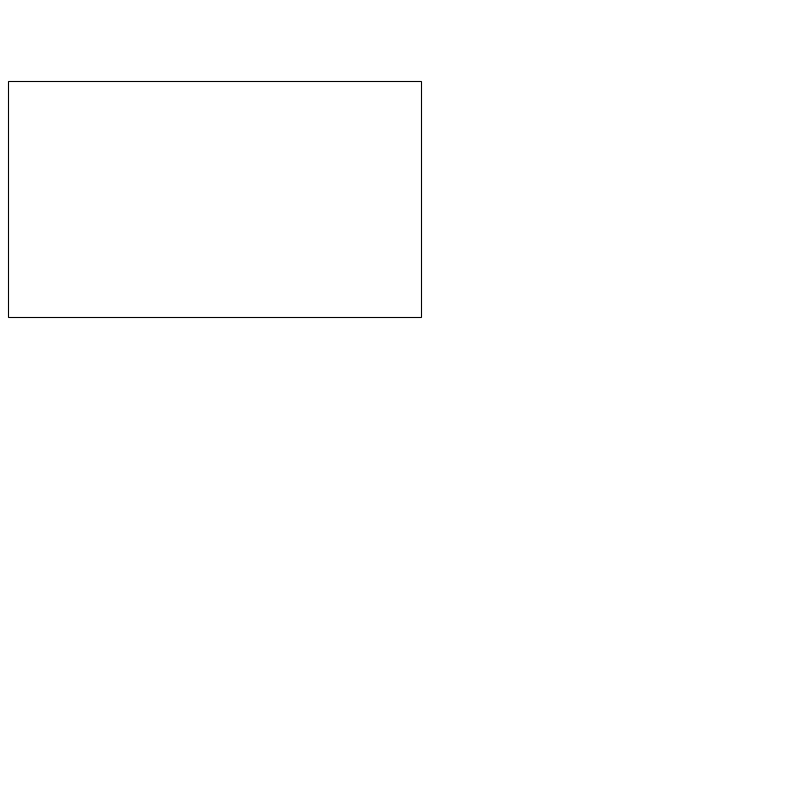

Text(0.5, 0.98, 'A grid of maps using built-in EOmaps WMS requests')

In [3]:
#set up the ipympl backend to render the interactive map in Jupyter Lab
%matplotlib widget

#set up MapsGrid figure (# rows/cols, space between subplots, CRS)
#accepts any kwargs used in matplotlib.gridspec.GridSpec class
mg = MapsGrid(r=2, c=2, hspace=0.05, wspace=-0.1, figsize=(8,8), crs=3338)

#set extent... note that even though we set 3338 as the CRS, we can still use the default 4326 coordinates... they are reprojected automagically :)
extent=(-140.5, -129.5, 52.5, 60.5)

#using m_<row>_<col> to access the maps in the grid, create each map using an AK coastline geodataframe and a WMS service
#note that we use a geodataframe that is in CRS 4326... it is reprojected automagically :)
mg.m_0_0.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mg.m_0_0.add_wms.OpenStreetMap.add_layer.default()
mg.m_0_0.set_extent(extent)

mg.m_0_1.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mg.m_0_1.add_wms.ESRI_ArcGIS.SERVICES.World_Shaded_Relief.add_layer.xyz_layer()
mg.m_0_1.set_extent(extent)

mg.m_1_0.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mg.m_1_0.add_wms.S2_cloudless.add_layer.bluemarble()
mg.m_1_0.set_extent(extent)

mg.m_1_1.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mg.m_1_1.add_wms.S1GBM.add_layer.vv()
mg.m_1_1.set_extent(extent)

#joins all map extents, so if you zoom on one map they all zoom to same extent
mg.join_limits()

#add a title << does not appear for some reason, need to figure that out!
mg.f.suptitle("A grid of maps using built-in EOmaps WMS requests")

## Multiscale NaturalEarth features

The finest scale (10) looks suitable for regional maps, with a good level of detail on the coastline and includes major rivers. The medium scale (50) would be suitable for a statewide map. The coarsest scale (110) is probably only good for continental scale maps.

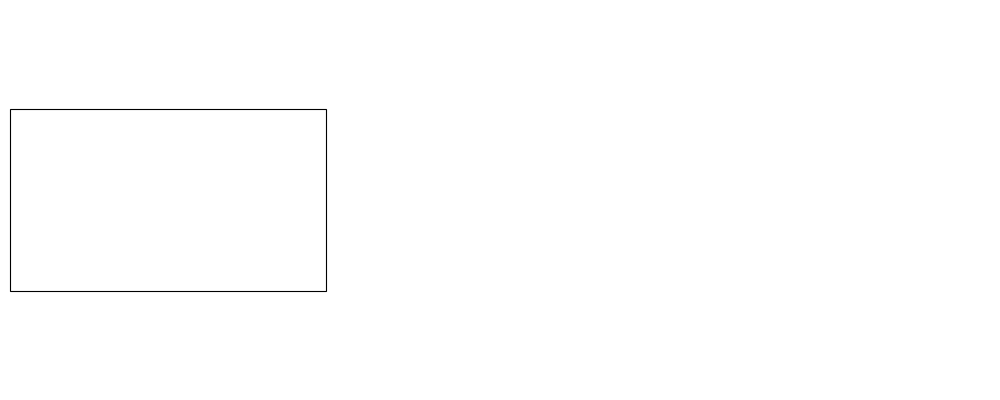

Text(0.5, 0.98, 'Comparison of NaturalEarth features at 3 different scales')

In [4]:
%matplotlib widget    

mk = MapsGrid(r=1, c=3, wspace=0.05, figsize=(10,4), crs=3338)
extent=(-140.5, -129.5, 52.5, 60.5)

#using m_<row>_<col> to access the maps in the grid, create each map using an AK coastline geodataframe
# add commonly used NaturalEarth features from eomaps presets (coast, ocean, land, lakes, rivers...)
# and more specific NaturalEarth features (glaciated areas)
# Note that NaturalEarth data is available at multiple scales, we compare them here in 3 maps

mk.m_0_0.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mk.m_0_0.add_feature.preset("coastline", "ocean", "land", "lakes", "rivers_lake_centerlines", scale=10)
mk.m_0_0.add_feature.physical.glaciated_areas(scale=10, color='lightgray')
mk.m_0_0.set_extent(extent)

mk.m_0_1.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mk.m_0_1.add_feature.preset("coastline", "ocean", "land", "lakes", "rivers_lake_centerlines", scale=50)
mk.m_0_1.add_feature.physical.glaciated_areas(scale=50, color='lightgray')
mk.m_0_1.set_extent(extent)

mk.m_0_2.add_gdf(ak_gdf.boundary, color='red', linewidth=0.5)
mk.m_0_2.add_feature.preset("coastline", "ocean", "land", "lakes", "rivers_lake_centerlines", scale=110)
mk.m_0_2.add_feature.physical.glaciated_areas(scale=110, color='lightgray') #<<< none show at this scale
mk.m_0_2.set_extent(extent)

mk.join_limits()

#add a title << does not appear for some reason, need to figure that out!
mk.f.suptitle("Comparison of NaturalEarth features at 3 different scales")

## Basemap + features + airports + plots

Of course formatting would add to the complexity but there is a lot of data here with not alot of code. Imagine the plots showing data values from the SNAP Data API for groups of features / individual features with callouts.

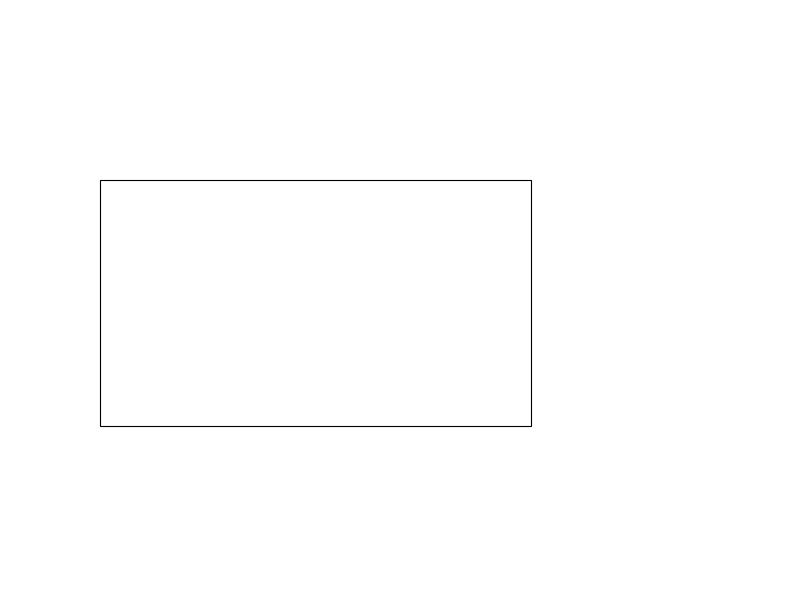

In [5]:
#get airport types (hubs & roles) from state of AK geoportal
#info here: https://gis.data.alaska.gov/datasets/DCCED::airport-roles/about
#Hub codes: 
    # N - Nonhub Primary
    # M - Medium Hub
    # S - Small Hub
with requests.Session() as s:
    url = "https://maps.commerce.alaska.gov/server/rest/services/Transportation/Transportation_Airport_HubRole/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"
    r = s.get(url).json()
airport_types = gpd.GeoDataFrame.from_features(r, crs=4326)

%matplotlib widget

ak = Maps(crs=3338,               
    layer="base",                  
    figsize=(8, 6),
    ax=(1,10,(1,7)))              
ak.set_extent((-179, -120, 50, 75))

ak.add_gdf(airport_types[airport_types['Hub']=='M'], marker='^', markersize=80, fc ='red', ec='black', zorder=5)
ak.add_gdf(airport_types[airport_types['Hub']=='S'], marker='^', markersize=65, fc ='orange', ec='black', zorder=4)
ak.add_gdf(airport_types[airport_types['Hub']=='N'], marker='^', markersize=45, fc ='green', ec='black', zorder=3)

ak.add_wms.ESRI_ArcGIS.SERVICES.World_Shaded_Relief.add_layer.xyz_layer(zorder=1)
ak.add_feature.physical.coastline(scale=50, ec='black', fc='none', zorder=2, alpha=0.5)

plot1 = ak.f.add_subplot(3,10,(9,10))
plot2 = ak.f.add_subplot(3,10,(19,20))
plot3 = ak.f.add_subplot(3,10,(29,30))

plot1.plot([1,3,5,7], [1,3,5,7], color='red')
plot2.plot([1,3,5,7], [1,3,5,7], color='orange')
plot3.plot([1,3,5,7], [1,3,5,7], color='green')


## Rasdaman WMS as Basemap

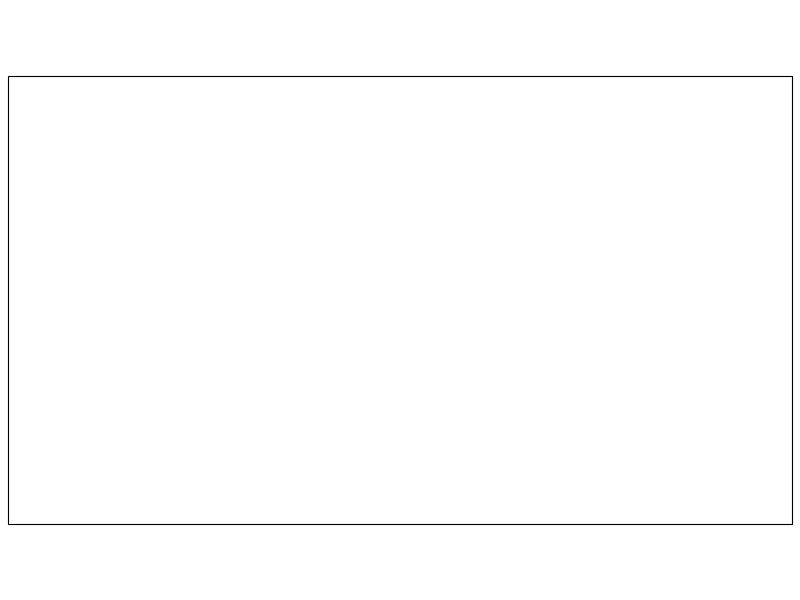

In [7]:
# TESTING RASDAMAN WMS to use as basemaps
# need to start with a magic spell to get cartopy to recognize EPSG:3338
%matplotlib widget

from cartopy.io.ogc_clients import _CRS_TO_OGC_SRS
_CRS_TO_OGC_SRS[Maps.CRS.epsg(3338)] = ["EPSG:3338"]

map = Maps(crs=3338, layer="all", figsize=(8, 6))              
map.set_extent((-179, -120, 50, 75))

# #add SNAP AK coastline gdf
map.add_gdf(ak_gdf.boundary, color='red', linewidth=1, alpha=0.5)

url = "https://apollo.snap.uaf.edu/rasdaman/ows?version=1.3.0&service=WMS&request=GetCapabilities"

ras_wms = map.add_wms.get_service(url, service_type="wms", rest_API=False, version='1.3.0')

#we use the WMS service object to add a new annual mean temp layer "t", which becomes an eomaps WMS Layer object
#layer info like dimensions, timesteps, and styles can be accessed from "t.info", "t.wms_layer.dimensions", "t.wms_layer.timepositions"
t = ras_wms.add_layer.annual_mean_temp

#add "t" to the map with default coordinates: last timestep, last model, last scenario (as mentioned here: https://doc.rasdaman.org/05_geo-services-guide.html#:~:text=If%20a%20non%2Dgeo%2Dreferenced%20axis%20is%20omitted%20from%20the%20request%20it%20will%20be%20considered%20as%20a%20slice%20on%20the%20upper%20bound%20along%20this%20axis.%20For%20example%2C%20in%20a%20time%2Dseries%20the%20most%20recent%20timeslice%20will%20be%20delivered.)
#t()

#or add "t" to the map by specifying timestep and dimensions. Note that time is a datetime string, and the dimensions are integers and their arguments have a "dim_" prefix...
#these arguments are passed directly to the GetMap request, and so for Rasdaman they follow the guidelines here: https://doc.rasdaman.org/05_geo-services-guide.html#nd-coverages-as-wms-layers
#since the WMS metadata does not describe what the model and scenario integers refer to, you need to view the coverage details to get the encodings: https://apollo.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=DescribeCoverage&COVERAGEID=annual_mean_temp

models = [0,1,1] #5 model average
scenarios = [0,3,3] #historical, rcp8.5, rcp8.5
times = ["2000-01-01T00:00:00.000Z","2050-01-01T00:00:00.000Z","2100-01-01T00:00:00.000Z"]
style = ['temp'] #this has to be passed as a list for some reason?

for time, model, scenario in zip(times, models, scenarios):
    # call the layer to add it to the map
    t(time=time,
      model=model,
      scenario=scenario, 
      styles=style, 
      layer=time)      # put each map on an individual layer

# fetch all layers so that they are cached and switching layers is fast
map.fetch_layers()

# add a "selector" widget
map.util.layer_selector(ncol=3, loc="upper center", fontsize=6, labelspacing=1.3, draggable=False)
# make the first timestamp visible
map.show_layer(times[0])      


# #add title
# map.add_title("Rasdaman WMS:\nTime: " + time + "\n5 Model Avg, RCP8.5\n")

In [28]:
t.wms_layer.styles['temp']['title']

'temp'

In [23]:
t.wms_layer.styles

{'temp': {'title': 'temp'},
 'temp_historical_era': {'title': 'temp_historical_era'},
 'temp_midcentury_era': {'title': 'temp_midcentury_era'}}

In [70]:
t.info


 LEGEND available: False

auth : <Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>
parent : <owslib.map.wms130.ContentMetadata object at 0x7ff3d18ee690>
index : '1.4'
id : 'annual_mean_temp'
name : 'annual_mean_temp'
opaque : 1
title : 'annual_mean_temp'
boundingBoxWGS84 : (-179.9999855706962,
                    48.968036106931436,
                    179.9516073998089,
                    71.55107407447652)
crs_list : [(...)]
boundingBox : (-2187223.206087799,
               396412.932644147,
               1510776.793912201,
               2394412.932644147,
               'EPSG:3338')
crsOptions : ['EPSG:3338']
styles : {'temp': {...},
          'temp_historical_era': {...},
          'temp_midcentury_era': {...}}
timepositions : ['"1901-01-01T00:00:00.000Z"',
                 '"1902-01-01T00:00:00.000Z"',
                 '"1903-01-01T00:00:00.000Z"',
                 '"1904-01-01T00:00:00.000Z"',
                 '"1905-01-01T00:0